In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import pickle
import seaborn as sns
import numpy as np

In [2]:
Weights = {"Walk": .695, "HitByPitch": .727,
           "Single": .891, "Double": 1.269,
            "Triple": 1.609, "HomeRun": 2.078}

In [3]:
kcl_Directory = "/Users/noahlippman/Documents/Kernelytics-Projects-main/CornBeltersData"
kcl_files = glob.glob(os.path.join(kcl_Directory, "*.csv"))
data = pd.read_csv(kcl_files[0])

for f in kcl_files[1:]:
    newGame = pd.read_csv(f)
    data = pd.concat([data,newGame], axis = 0)

In [4]:
# Create the corrections dictionary
corrections = {
    "Kannan Kleine" : "Kannon Kleine"
}

# Define the function to fix names
def fix_names(df, column, lookup):
    df[column] = df[column].apply(lambda name: lookup.get(name, name))
    return df

data = fix_names(data, "Batter", corrections)

In [5]:
data['RunValue'] = data['PlayResult'].map(Weights)
data['RunValue'] = data['RunValue'].fillna(0)
data['Whiff'] = np.where(data['PitchCall'] == "StrikeSwinging", 1, 0)

In [6]:
Contact_Data = data[(data['PitchCall'] == "InPlay") & (data['ExitSpeed'].notna()) & (data['Angle'].notna())]
len(Contact_Data)
Contact_Data

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,...,yt_ZoneAccuracy,yt_SeamLat,yt_SeamLong,yt_ReleaseDistance,Catcher,CatcherId,CatcherTeam,yt_AeroModel,RunValue,Whiff
0,1,5/28/2025,6:30:18 PM,1,1,Graham Kasey,NaN,Left,Normal cornbelters,Connor Kave,...,high,28.830890,-66.550145,54.667002,Charlie Graham,NaN,Normal cornbelters,2022-11,0.000,0
7,8,5/28/2025,6:32:52 PM,3,1,Graham Kasey,NaN,Left,Normal cornbelters,Kooper Schulte,...,high,44.405560,-59.744765,54.667002,Charlie Graham,NaN,Normal cornbelters,2022-11,0.000,0
10,11,5/28/2025,6:35:41 PM,1,3,Alex Logan,NaN,Right,Burlington bees 2025,Ryan Colucci,...,high,45.009103,-54.525557,54.667002,Dominic Texeira,NaN,Burlington bees 2025,2022-11,0.000,0
15,16,5/28/2025,6:37:47 PM,3,3,Alex Logan,NaN,Right,Burlington bees 2025,Zach Zychowski,...,high,96.505534,22.869682,54.667002,Dominic Texeira,NaN,Burlington bees 2025,2022-11,0.000,0
17,18,5/28/2025,6:38:38 PM,4,2,Alex Logan,NaN,Right,Burlington bees 2025,Jackson Smith,...,high,23.844936,26.375204,54.667002,Dominic Texeira,NaN,Burlington bees 2025,2022-11,0.891,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,217,6/5/2025,8:33:22 PM,6,4,Samuel Guadamuz,NaN,Right,Rex baseball 2025,Ryan Colucci,...,high,52.419331,66.143370,54.667002,Ben Jones,NaN,Rex baseball 2025,2022-11,1.269,0
240,242,6/5/2025,8:48:25 PM,4,4,Will O'gorman,NaN,Left,Normal cornbelters,Gabe Wright,...,high,NaN,NaN,54.667002,Kannan Kleine,NaN,Normal cornbelters,2022-11,0.000,0
261,263,6/5/2025,9:02:03 PM,6,5,Brad Nardi,NaN,Left,Rex baseball 2025,Nolan Mccrossin,...,high,43.892432,37.257329,54.667002,Ben Jones,NaN,Rex baseball 2025,2022-11,0.000,0
264,266,6/5/2025,9:05:30 PM,1,3,Alec Bergman,NaN,Right,Normal cornbelters,Emil Estrella,...,high,13.889505,50.274761,54.667002,Kannan Kleine,NaN,Normal cornbelters,2022-11,0.000,0


In [7]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsRegressor

X = Contact_Data[['ExitSpeed', 'Angle']]
Y = Contact_Data['RunValue'] 

def CV():
    k_scores = {}
    for i in range(1,30):
        xwoba_model = KNeighborsRegressor(n_neighbors = i)
        k_folds = KFold(n_splits = 5)
        scores = cross_val_score(xwoba_model, X, Y, cv = k_folds, scoring = 'neg_root_mean_squared_error') * -1
        k_scores[i] = scores.mean()
    return k_scores

scores = CV()

Text(0, 0.5, 'RMSE')

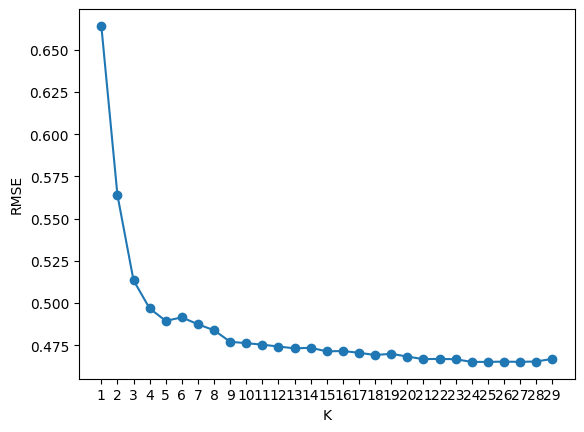

In [8]:
K_vals = scores.keys()
RMSE_vals = scores.values()
plt.scatter(K_vals,RMSE_vals)
plt.plot(K_vals,RMSE_vals)
plt.xticks([i for i in range(1,30)])
plt.xlabel("K")
plt.ylabel("RMSE")

In [9]:
xwoba_model = KNeighborsRegressor(n_neighbors = 20)
xwoba_model.fit(X,Y)

KNeighborsRegressor(n_neighbors=20)

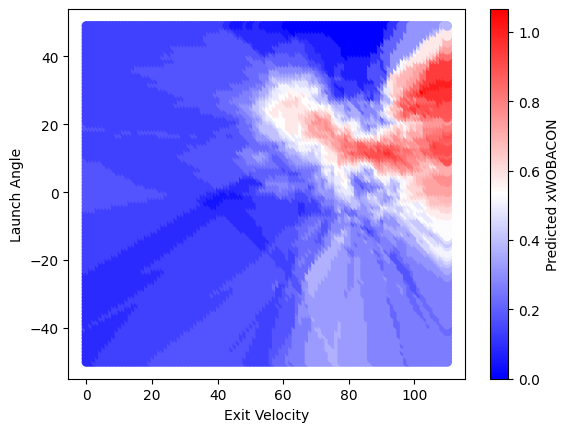

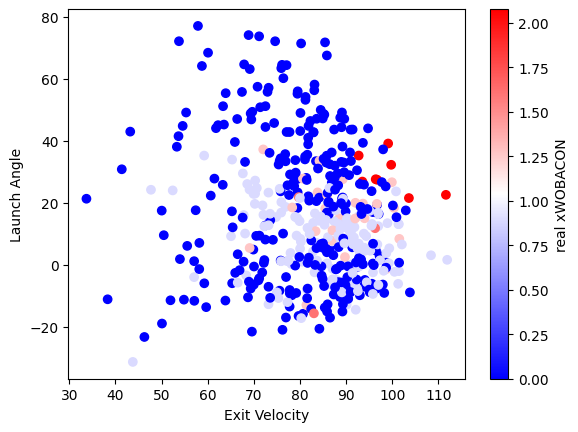

In [10]:
from itertools import product

exit_speeds = range(0,111,1)
launch_angles = range(-50,50,1)
combinations = list(product(exit_speeds, launch_angles))

sim_data = pd.DataFrame(combinations, columns = ['ExitSpeed', 'Angle'])
sim_data['predictedRunValue'] = xwoba_model.predict(sim_data)

X_sim = sim_data['ExitSpeed']
Y_sim = sim_data['Angle']
Z_sim = sim_data['predictedRunValue']

plt.scatter(X_sim,Y_sim,c = Z_sim, cmap = 'bwr')
plt.xlabel("Exit Velocity")
plt.ylabel("Launch Angle")
plt.colorbar(label = "Predicted xWOBACON")
plt.show()

X_real = Contact_Data['ExitSpeed']
Y_real = Contact_Data['Angle']
Z_real = Contact_Data['RunValue']

plt.scatter(X_real,Y_real,c = Z_real, cmap = 'bwr')
plt.xlabel("Exit Velocity")
plt.ylabel("Launch Angle")
plt.colorbar(label = "real xWOBACON")
plt.show()


In [11]:
def event_predict(event):
    if(not pd.isna(event['ExitSpeed']) and not pd.isna(event['Angle']) and event['PitchCall'] == "InPlay"):
        return xwoba_model.predict([[event['ExitSpeed'], event['Angle']]])[0]
    elif(event['KorBB'] == "Strikeout"):
        return 0
    elif(event['KorBB'] == "Walk"):
        return .695
    elif((pd.isna(event['ExitSpeed']) or pd.isna(event['Angle'])) and event['PitchCall'] == "InPlay"):
        return event['RunValue']

In [12]:
data['xWOBA'] = data.apply(event_predict, axis = 1)
data['xWOBA']
data.to_csv("/Users/noahlippman/Documents/xWOBAFolder_Belters/Pitch_By_Pitch_xWOBA_Belters.csv")

c:\Users\isu_mvquirk_admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
c:\Users\isu_mvquirk_admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
c:\Users\isu_mvquirk_admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
c:\Users\isu_mvquirk_admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
c:\Users\isu_mvquirk_admin\AppData\Local

OSError: Cannot save file into a non-existent directory: '\Users\noahlippman\Documents\xWOBAFolder_Belters'

Lets now calculate each individual player's xWOBA

In [ ]:
hitters = data[data['BatterTeam'] == "Normal cornbelters"]['Batter'].unique()
hitterDict = {}

for hitter in hitters:
    hitter_data = data[data['Batter'] == hitter]
    hitter_data = hitter_data[hitter_data['PlayResult'].notna()]
    xWOBA = hitter_data['xWOBA'].mean()
    hitterDict[hitter] = round(xWOBA,3)
hitters_data = pd.DataFrame(hitters, columns = ['Batter'])
hitters_data['xWOBA'] = hitters_data['Batter'].map(hitterDict)

hitters_data = hitters_data.sort_values(by = 'xWOBA', ascending = False)
hitters_data['Rank'] = range(len(hitters_data['Batter']))
hitters_data['Percentile'] = (len(hitters_data['xWOBA']) - hitters_data['Rank'])/len(hitters_data) *100
hitters_data.drop("Rank", inplace = True, axis = 1)
hitters_data.to_csv("/Users/noahlippman/Documents/xWOBAFolder/Hitter_XWOBA.csv")
hitters_data

,Batter,xWOBA,Percentile
4,Tyler Thompson,0.367,100.000000
7,Michael Kuska,0.356,92.307692
5,Zach Zychowski,0.326,84.615385
3,Caleb Royer,0.320,76.923077
2,Jackson Smith,0.317,69.230769
10,Cole Freeman,0.301,61.538462
0,Shea Zbrozek,0.277,53.846154
1,Jack Novak,0.268,46.153846
9,Jackson Stanek,0.255,38.461538
6,Nolan Mccrossin,0.252,30.769231


In [ ]:
hitters_data.to_csv('/Users/noahlippman/Documents/xWOBAFolder_Belters/xWOBA_Data_Belters.csv')

In [ ]:
def x_zone(cord):
    if(cord < 1 and cord >= .3333):
        return 1
    elif(cord < .3333 and cord >= -.3333):
        return 2
    elif(cord < -.3333 and cord >= -1):
        return 3
    
def y_zone(cord):
    if(cord > 1.5 and cord <= 2.17):
        return 3
    elif(cord > 2.17 and cord <= 2.83):
        return 2
    elif(cord > 2.83 and cord <= 3.5):
        return 1

/var/folders/vd/06ct10nj485cm3hk0nq7zy8h0000gn/T/ipykernel_48420/3872704156.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heat_data['xZone'] = heat_data['PlateLocSide'].map(x_zone)
/var/folders/vd/06ct10nj485cm3hk0nq7zy8h0000gn/T/ipykernel_48420/3872704156.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heat_data['yZone'] = heat_data['PlateLocHeight'].map(y_zone)
/var/folders/vd/06ct10nj485cm3hk0nq7zy8h0000gn/T/ipykernel_48420/3872704156.py:5: SettingWithCopyWarning: 
A value is trying to be set o

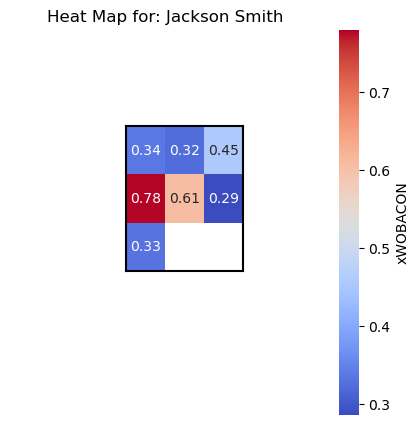

xZone,1.0,2.0,3.0
yZone,,,
1.0,0.33075,NaN,NaN
2.0,0.77975,0.607712,0.28620
3.0,0.33815,0.322920,0.45495


In [75]:
def heat_map_hitter(batter_name):
    heat_data = Contact_Data[Contact_Data['Batter'] == batter_name]
    heat_data['xZone'] = heat_data['PlateLocSide'].map(x_zone)
    heat_data['yZone'] = heat_data['PlateLocHeight'].map(y_zone)
    heat_data['xWOBACON'] = (xwoba_model.predict(heat_data[['ExitSpeed', 'Angle']]))

    heat_pivot = pd.pivot_table(data = heat_data,
                                values = "xWOBACON",
                                index = "yZone",
                                columns = "xZone",
                                aggfunc = "mean")
    fig, ax = plt.subplots(figsize = (5,5))
    sns.heatmap(heat_pivot, cmap = "coolwarm", annot = True, cbar_kws = {'label': 'xWOBACON'})
    plt.axis('off')
    ax.set_xlim(-3,5)
    ax.set_ylim(-3,5)
    plt.plot([0,3], [0,0], c = 'black')
    plt.plot([0,3], [3,3], c = 'black')
    plt.plot([0,0], [0,3], c = 'black')
    plt.plot([3,3], [0,3], c = 'black')
    plt.title("Heat Map for: " + batter_name)
    plt.show()
    return heat_pivot
heat_map_hitter("Jackson Smith")

/var/folders/vd/06ct10nj485cm3hk0nq7zy8h0000gn/T/ipykernel_48420/2459438364.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heat_data['xZone'] = heat_data['PlateLocSide'].map(x_zone)
/var/folders/vd/06ct10nj485cm3hk0nq7zy8h0000gn/T/ipykernel_48420/2459438364.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heat_data['yZone'] = heat_data['PlateLocHeight'].map(y_zone)
/var/folders/vd/06ct10nj485cm3hk0nq7zy8h0000gn/T/ipykernel_48420/2459438364.py:9: SettingWithCopyWarning: 
A value is trying to be set o

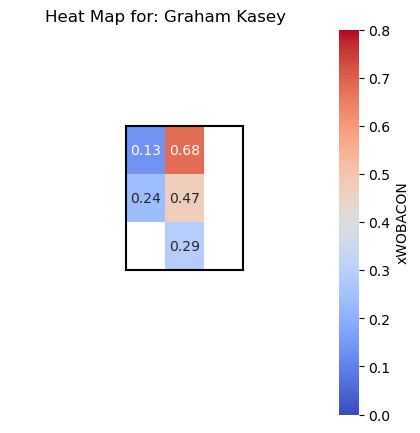

xZone,2.0,3.0
yZone,,
1,NaN,0.293183
2,0.236475,0.468400
3,0.133650,0.678500


In [76]:
def heat_map_pitcher(pitcher_name, pitch_type = None):
    if pitch_type == None:
        heat_data = Contact_Data[Contact_Data['Pitcher'] == pitcher_name]
    else:
        heat_data = Contact_Data[(Contact_Data['Pitcher'] == pitcher_name) & (Contact_Data['TaggedPitchType'] == pitch_type)]

    heat_data['xZone'] = heat_data['PlateLocSide'].map(x_zone)
    heat_data['yZone'] = heat_data['PlateLocHeight'].map(y_zone)
    heat_data['xWOBACON'] = (xwoba_model.predict(heat_data[['ExitSpeed', 'Angle']]))

    heat_pivot = pd.pivot_table(data = heat_data,
                                values = "xWOBACON",
                                index = "yZone",
                                columns = "xZone",
                                aggfunc = "mean")
    fig, ax = plt.subplots(figsize = (5,5))
    sns.heatmap(heat_pivot, cmap = "coolwarm", annot = True, cbar_kws = {'label': 'xWOBACON'}, vmin = 0, vmax = .8)
    plt.axis('off')
    ax.set_xlim(-3,5)
    ax.set_ylim(-3,5)
    plt.plot([0,3], [0,0], c = 'black')
    plt.plot([0,3], [3,3], c = 'black')
    plt.plot([0,0], [0,3], c = 'black')
    plt.plot([3,3], [0,3], c = 'black')
    plt.title("Heat Map for: " + pitcher_name)
    plt.show()
    return heat_pivot

heat_map_pitcher("Graham Kasey")

/var/folders/vd/06ct10nj485cm3hk0nq7zy8h0000gn/T/ipykernel_48420/3032517277.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  whiff_data['xZone'] = whiff_data['PlateLocSide'].map(x_zone)
/var/folders/vd/06ct10nj485cm3hk0nq7zy8h0000gn/T/ipykernel_48420/3032517277.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  whiff_data['yZone'] = whiff_data['PlateLocHeight'].map(y_zone)


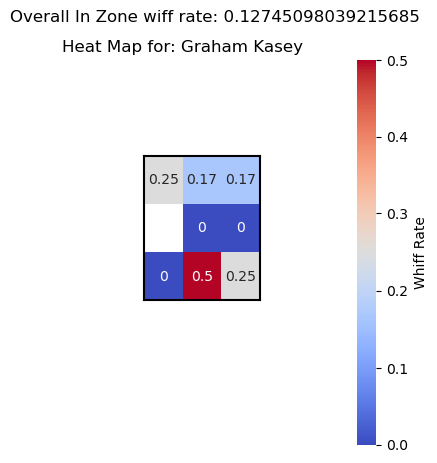

xZone,1.0,2.0,3.0
yZone,,,
1.0,0.00,0.500000,0.250000
2.0,NaN,0.000000,0.000000
3.0,0.25,0.166667,0.166667


In [77]:
def whiff_map_pitcher(pitcher_name, pitch_type = None):
    if pitch_type == None:
        whiff_data = data[data['Pitcher'] == pitcher_name]
    else:
        whiff_data = data[(data['Pitcher'] == pitcher_name) & (data['TaggedPitchType'] == pitch_type)]

    whiff_data['xZone'] = whiff_data['PlateLocSide'].map(x_zone)
    whiff_data['yZone'] = whiff_data['PlateLocHeight'].map(y_zone)

    heat_pivot = pd.pivot_table(data = whiff_data,
                                values = "Whiff",
                                index = "yZone",
                                columns = "xZone",
                                aggfunc = "mean")
    fig, ax = plt.subplots(figsize = (5,5))
    sns.heatmap(heat_pivot, cmap = "coolwarm", annot = True, cbar_kws = {'label': 'Whiff Rate'})
    plt.axis('off')
    ax.set_xlim(-3,5)
    ax.set_ylim(-3,5)
    plt.plot([0,3], [0,0], c = 'black')
    plt.plot([0,3], [3,3], c = 'black')
    plt.plot([0,0], [0,3], c = 'black')
    plt.plot([3,3], [0,3], c = 'black')
    plt.title("Heat Map for: " + pitcher_name)
    plt.suptitle("Overall In Zone wiff rate: " + str(whiff_data['Whiff'].mean()))
    plt.show()
    return heat_pivot

whiff_map_pitcher("Graham Kasey")